### 分类模型评价方法

In [1]:
import pandas as pd

df = pd.read_csv(
    "data/credit_risk_train.csv")  # 读取数据文件
df.head()

,BILL_1,BILL_2,BILL_3,BILL_4,BILL_5,BILL_6,AGE,SEX,EDUCATION,MARRIAGE,RISK
0,0,0,0,0,0,0,37,Female,Graduate School,Married,LOW
1,8525,5141,5239,7911,17890,10000,25,Male,High School,Single,HIGH
2,628,662,596,630,664,598,39,Male,Graduate School,Married,HIGH
3,4649,3964,3281,934,467,12871,41,Female,Graduate School,Single,HIGH
4,46300,10849,8857,9658,9359,9554,55,Female,High School,Married,HIGH


该数据集包含 10 列特征，以及一列类别标签。其中：

    第 1～6 列为客户近期历史账单信息。（特征）
    第 7 列为该客户年龄。（特征）
    第 8 列为该客户性别。（特征）
    第 9 列为该客户教育程度。（特征）
    第 10 列为该客户婚姻状况。（特征）
    第 11 列为客户持卡风险状况。（分类标签：LOW, HIGH）

目的:利用该数据集训练一个信用卡持卡人风险预测模型，并对模型进行评价。  
首先，按照机器学习建模的流程，将数据集划分为训练集和测试集。

第 7，8，9 列的特征数据为类别型（Female / Male）。所以，这里在划分数据集的同时，使用独热编码将类别型特征转换为数值型特征。

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

df.RISK = df.RISK.replace({"LOW": 0, "HIGH": 1})  # 将分类标签替换为数值，方便后面计算

train_data = df.iloc[:, :-1]  # 特征数据列
train_data = pd.get_dummies(train_data)  # 对特征数据进行独热编码
train_data = scale(train_data)  # 规范化处理

train_target = df['RISK']  # 目标数据列

# 划分数据集，训练集占 70%，测试集占 30%
X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_target, test_size=0.3, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14000, 16), (6000, 16), (14000,), (6000,))

In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')  # 定义逻辑回归模型
model.fit(X_train, y_train)  # 使用训练数据完成模型训练

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 准确率 Accuracy

| 信用风险 | HIGH | LOW |
|:--------:|:------------------:|:------------------:|
| HIGH | True Positive (TP) | False Negative (FN) |
| LOW | False Positive (FP) | True Negative (TN) |

- TP：将正类预测为正类数 → 预测正确
- TN：将负类预测为负类数 → 预测正确
- FP：将负类预测为正类数 → 预测错误
- FN：将正类预测为负类数 → 预测遗漏
$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN} 
$$
$$
acc=\frac{\sum_{i=1}^{N}I(\bar{y_{i}}=y_{i})}{N} 
$$

In [5]:
y_pred = model.predict(X_test)  # 输入测试集特征数据得到预测结果
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [6]:
import numpy as np

def get_accuracy(test_labels, pred_lables):
    # 准确率计算公式，根据公式 2 实现
    correct = np.sum(test_labels == pred_lables)  # 计算预测正确的数据个数
    n = len(test_labels)  # 总测试集数据个数
    acc = correct/n
    return acc

In [7]:
get_accuracy(y_test, y_pred)  # 计算模型预测准确率

0.7678333333333334

直接使用准确率的 scikit-learn 计算方法

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)  # 传入真实类别和预测类别

0.7678333333333334

scikit-learn 建模时也可以直接使用 model.score() 求得分类准确率

In [9]:
model.score(X_test, y_test)  # 传入测试数据特征和类别

0.7678333333333334

### 查准率 Precision

查准率又称精确率，即正确分类的正例个数占分类为正例的实例个数的比例。
$$Precision = \frac{TP}{TP+FP} \tag{3}$$

In [12]:
from sklearn.metrics import precision_score

precision_score(y_test, y_pred)

0.7678333333333334

### 召回率 Recall

召回率又称查全率，即正确分类的正例个数占实际正例个数的比例。

$$Recall = \frac{TP}{TP+FN} \tag{4}$$

In [13]:
from sklearn.metrics import recall_score

recall_score(y_test, y_pred)

1.0

### F1 值

F1 值是查准率和召回率的加权平均数。F1 相当于精确率和召回率的综合评价指标，对衡量数据更有利，也比较常用。

$$F1 = \frac{2*(Precision * Recall)}{Precision + Recall} \tag{5}$$

In [14]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.8686716319411709

### ROC 曲线

部分分类模型中（如：逻辑回归），通常会设定一个阈值，并规定大于该阈值为正类，小于则为负类。所以，当我们减小阀值时，将会有更多的样本被划分到正类。这样会提高正类的识别率，但同时也会使得更多的负类被错误识别为正类。
所以，ROC 曲线的目的在用形象化该变化过程，从而评价一个分类器好坏。

ROC 曲线中有两个指标，分别是 TPR 和 FPR：

$$TPR = \frac{TP}{TP+FN} \tag{6a}$$

$$FPR = \frac{FP}{FP+TN} \tag{6b}$$

其中，TPR 代表能将正例分对的概率（召回率），而 FPR 则代表将负例错分为正例的概率。

![image](https://doc.shiyanlou.com/document-uid214893labid7506timestamp1540448403508.png)
<div style="color: #888; font-size: 10px; text-align: right;"><a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic"><i class="fa fa-copyright" aria-hidden="true"> 来源</i></a></div>

- 当 FPR=0，TPR=0 时，意味着将每一个实例都预测为负例。
- 当 FPR=1，TPR=1 时，意味着将每一个实例都预测为正例。
- 当 FPR=0，TPR=1 时，意味着为最优分类器点。

一个优秀分类器对应的 ROC 曲线应该尽量靠近左上角。当曲线越接近于 45 度对角线，则分类器效果越差。

ROC 曲线的 scikit-learn 计算方法：`sklearn.metrics.roc_curve(y_true, y_score)`。

In [19]:
from sklearn.metrics import roc_curve
 
roc_curve(y_test, y_pred)

(array([0., 1.]), array([0., 1.]), array([2, 1], dtype=int64))

虽然使用 ROC 曲线来表示分类器好坏很直观，但人们往往更喜欢使用数值来评价分类器，此时就提出了 AUC 的概念。AUC 的全称为 Area Under Curve，意思是曲线下面积，即 ROC 曲线下面积。


- $AUC=1$：完美分类器。
- $0.5<AUC<1$：分类器优于随机猜测。
- $AUC=0.5$：分类器和随机猜测的结果接近。
- $AUC<0.5$：分类器比随机猜测的结果还差。

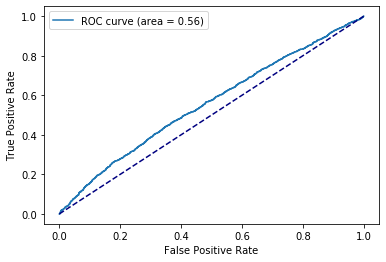

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_score = model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()